# Assignment 2
## Harshit Aggarwal | 2021111015

In [2]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import wandb
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torch.nn.functional as F
from lion_pytorch import Lion

# Q 1.1

In [183]:
def compute_sift_features(dataset, sift):
    keypoints_list = []
    descriptors_list = []
    for img, _ in dataset:
        img = img.reshape((img.shape[1], img.shape[2]))
        img = np.array(img)
        img = (img * 255).astype(np.uint8)
        keypoints, descriptors = sift.detectAndCompute(img, None)
        keypoints_list.append(keypoints)
        descriptors_list.append(descriptors)
    return keypoints_list, descriptors_list

In [173]:
def compute_visual_words(descriptors_list, num_clusters):
    descriptors_list = [desc for desc in descriptors_list if desc is not None and not np.any(np.isnan(desc))]
    if len(descriptors_list) == 0:
        raise ValueError("No valid descriptors found")
    descriptors = np.vstack(descriptors_list)
    kmeans = KMeans(n_clusters=num_clusters, n_init=10)
    kmeans.fit(descriptors)
    return kmeans.cluster_centers_, kmeans

In [174]:
def compute_histograms(descriptors_list, visual_words, kmeans):
    histograms = []
    for descriptors in descriptors_list:
        histogram = np.zeros(len(visual_words))

        if descriptors is None or np.any(np.isnan(descriptors)):
            histogram = np.zeros(len(visual_words))
        else:
            labels = kmeans.predict(descriptors)
            for label in labels:
                histogram[label] += 1

        histograms.append(histogram)
    return histograms

In [182]:
def train_svm_model(X_train, y_train):
    svm = SVC(kernel='linear')
    svm.fit(X_train, y_train)
    return svm

In [216]:
def train_svm_model_with_parameters(X_train, y_train, kernel, c, gamma):
    svm = SVC(kernel=kernel, C=c, gamma=gamma)
    svm.fit(X_train, y_train)
    return svm

In [176]:
def test_svm_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [219]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

In [220]:
sift = cv2.SIFT_create()
train_keypoints, train_descriptors = compute_sift_features(train_dataset, sift)
test_keypoints, test_descriptors = compute_sift_features(test_dataset, sift)

In [221]:
print(len(train_descriptors))

60000


In [167]:
num_clusters = 100
visual_words, kmeans = compute_visual_words(train_descriptors, num_clusters)

In [168]:
train_histograms = compute_histograms(train_descriptors, visual_words, kmeans)
test_histograms = compute_histograms(test_descriptors, visual_words, kmeans)

In [169]:
X_train = np.array(train_histograms)
y_train = np.array(train_dataset.targets)
svm_model = train_svm_model(X_train, y_train)

In [170]:
X_test = np.array(test_histograms)
y_test = np.array(test_dataset.targets)
accuracy = test_svm_model(svm_model, X_test, y_test)
print("Accuracy:", accuracy*100)

Accuracy: 75.33999999999999


# Q1.2

In [222]:
accuracies = []
for num_clusters in [3, 10, 30, 100, 300, 1000]:
    visual_words, kmeans = compute_visual_words(train_descriptors, num_clusters)
    train_histograms = compute_histograms(train_descriptors, visual_words, kmeans)
    test_histograms = compute_histograms(test_descriptors, visual_words, kmeans)
    X_train = np.array(train_histograms)
    y_train = np.array(train_dataset.targets)
    svm_model = train_svm_model(X_train, y_train)
    X_test = np.array(test_histograms)
    y_test = np.array(test_dataset.targets)
    accuracy = test_svm_model(svm_model, X_test, y_test)
    accuracies.append(accuracy)
    print("Accuracy:", accuracy*100)

Accuracy: 24.95
Accuracy: 42.309999999999995
Accuracy: 59.81999999999999
Accuracy: 74.95
Accuracy: 82.43
Accuracy: 85.58


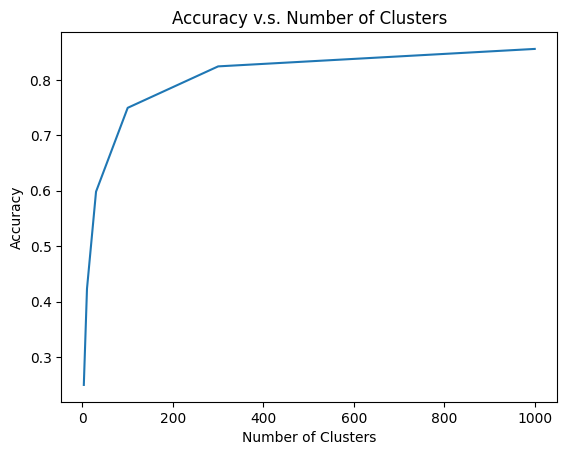

In [223]:
x_values = [3, 10, 30, 100, 300, 1000]
plt.plot(x_values, accuracies)
plt.xlabel('Number of Clusters')
plt.ylabel('Accuracy')
plt.title('Accuracy v.s. Number of Clusters')
plt.show()

# Observaton:
The classification accuracy increases as the number of clusters increase since the number offeatures between the images increase and thus, we have more visual words to classify.

# Q1.3

In [217]:
hyperparameters = [
    {'nfeatures': 200, 'sigma': 1.5, 'edgeThreshold': 10, 'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'},
    {'nfeatures': 300, 'sigma': 2.0, 'edgeThreshold': 15, 'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'},
    {'nfeatures': 400, 'sigma': 2.5, 'edgeThreshold': 20, 'C': 10.0, 'gamma': 0.001, 'kernel': 'rbf'},
    {'nfeatures': 250, 'sigma': 1.0, 'edgeThreshold': 5, 'C': 0.01, 'gamma': 0.1, 'kernel': 'poly'},
    {'nfeatures': 350, 'sigma': 3.0, 'edgeThreshold': 25, 'C': 100.0, 'gamma': 0.01, 'kernel': 'rbf'},
    {'nfeatures': 450, 'sigma': 2.0, 'edgeThreshold': 15, 'C': 0.1, 'gamma': 0.01, 'kernel': 'sigmoid'}
]

accuracies = []
for params in hyperparameters:
    number_of_clusters = 300
    sift = cv2.SIFT_create(nfeatures=params['nfeatures'], sigma=params['sigma'], edgeThreshold=params['edgeThreshold'])
    train_keypoints, train_descriptors = compute_sift_features(train_dataset, sift)
    test_keypoints, test_descriptors = compute_sift_features(test_dataset, sift)
    visual_words, kmeans = compute_visual_words(train_descriptors, num_clusters)
    train_histograms = compute_histograms(train_descriptors, visual_words, kmeans)
    test_histograms = compute_histograms(test_descriptors, visual_words, kmeans)
    X_train = np.array(train_histograms)
    y_train = np.array(train_dataset.targets)
    svm_model = train_svm_model_with_parameters(X_train, y_train, params['kernel'], params['C'], params['gamma'])
    X_test = np.array(test_histograms)
    y_test = np.array(test_dataset.targets)
    accuracy = test_svm_model(svm_model, X_test, y_test)
    accuracies.append(accuracy)
    print("Accuracy:", accuracy*100)

Accuracy: 83.35000000000001
Accuracy: 79.0
Accuracy: 68.69
Accuracy: 20.48
Accuracy: 58.379999999999995
Accuracy: 68.99


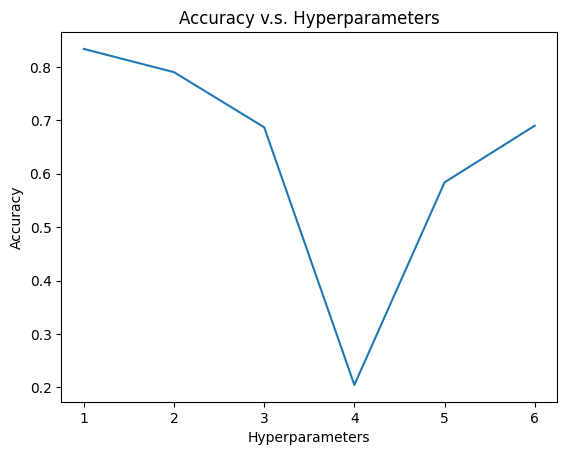

In [218]:
x_values = [1, 2, 3, 4, 5, 6]
plt.plot(x_values, accuracies)
plt.xlabel('Hyperparameters')
plt.ylabel('Accuracy')
plt.title('Accuracy v.s. Hyperparameters')
plt.show()

# Observations:
We can see the accuracy on different Hyperparameter combinations. The highest is for the 1st combination. 

In [102]:
def gaussian_kernel(size, sigma):
    kernel = np.fromfunction(lambda x, y: (1/(2*np.pi*sigma**2)) * np.exp(-((x - (size-1)/2)**2 + (y - (size-1)/2)**2) / (2*sigma**2)), (size, size))
    return kernel / np.sum(kernel)

In [104]:
def convolve(image, kernel):
    kernel = np.flipud(np.fliplr(kernel))
    output = np.zeros_like(image)
    image_padded = np.zeros((image.shape[0]+2, image.shape[1]+2))
    image_padded[1:-1, 1:-1] = image
    for x in range(image.shape[1]):
        for y in range(image.shape[0]):
            output[y,x]=(kernel*image_padded[y:y+kernel.shape[0],x:x+kernel.shape[1]]).sum()
    return output

In [105]:
def gradient(image):
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    gradient_x = convolve(image, sobel_x)
    gradient_y = convolve(image, sobel_y)
    magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    orientation = np.arctan2(gradient_y, gradient_x)
    return magnitude, orientation

In [108]:
def get_blurred(image, num_scales):
    blurred = []
    sigma = 1.6
    k = 2 ** (1 / num_scales)
    for _ in range(num_scales + 2):
        sigma *= k
        smoothed = cv2.GaussianBlur(image, (5, 5), sigma)
        dog = smoothed - image
        blurred.append(dog)
        image = smoothed
    return blurred

In [112]:
def get_candidate_keypoints(blurred, w=16):
    keypoints = []
    for k in range(1, blurred.shape[0]-1):
        for i in range(w//2+1, blurred.shape[1]-w//2+1):
            for j in range(w//2+1, blurred.shape[2]-w//2-1):
                if np.argmax(blurred[k-1:k+2, i-1:i+2, j-1:j+2]) == 13 or np.argmin(blurred[k-1:k+2, i-1:i+2, j-1:j+2]) == 13:
                    keypoints.append((i, j, k))
    return keypoints

In [120]:
def computeGradientAtCenterPixel(pixel_array):
    dx = 0.5 * (pixel_array[1, 1, 2] - pixel_array[1, 1, 0])
    dy = 0.5 * (pixel_array[1, 2, 1] - pixel_array[1, 0, 1])
    ds = 0.5 * (pixel_array[2, 1, 1] - pixel_array[0, 1, 1])
    return np.array([dx, dy, ds])

In [121]:
def computeHessianAtCenterPixel(pixel_array):
    center_pixel_value = pixel_array[1, 1, 1]
    dxx = pixel_array[1, 1, 2] - 2 * center_pixel_value + pixel_array[1, 1, 0]
    dyy = pixel_array[1, 2, 1] - 2 * center_pixel_value + pixel_array[1, 0, 1]
    dss = pixel_array[2, 1, 1] - 2 * center_pixel_value + pixel_array[0, 1, 1]
    dxy = 0.25 * (pixel_array[1, 2, 2] - pixel_array[1, 2, 0] - pixel_array[1, 0, 2] + pixel_array[1, 0, 0])
    dxs = 0.25 * (pixel_array[2, 1, 2] - pixel_array[2, 1, 0] - pixel_array[0, 1, 2] + pixel_array[0, 1, 0])
    dys = 0.25 * (pixel_array[2, 2, 1] - pixel_array[2, 0, 1] - pixel_array[0, 2, 1] + pixel_array[0, 0, 1])
    return np.array([[dxx, dxy, dxs], 
                  [dxy, dyy, dys],
                  [dxs, dys, dss]])

In [126]:
def find_keypoints_for_DoG_octave(keypoints, blurred, R_th, t_c): 
  a = keypoints
  keypoints = []
  for k, c in enumerate(a): 
    i, j, s = c[0], c[1], c[2]
    first_image, second_image, third_image = blurred[s-1:s+2]
    pixel_cube = np.stack([first_image[i-1:i+2, j-1:j+2],
                        second_image[i-1:i+2, j-1:j+2],
                        third_image[i-1:i+2, j-1:j+2]]).astype('float32') / 255.0
    gradient = computeGradientAtCenterPixel(pixel_cube)
    hessian = computeHessianAtCenterPixel(pixel_cube)
    offset = -np.linalg.inv(hessian).dot(gradient)
    H = hessian[:2,:2]
    contrast = blurred[i,j,s] + 0.5*gradient.dot(offset) 
    if abs(contrast) < t_c: 
      continue 
    w, v = np.linalg.eig(H)
    r = w[1]/w[0]
    R = (r+1)**2 / r
    if R > R_th:
      continue 
    kp = np.array([i, j, s]) + offset
    keypoints.append(kp)
  return np.array(keypoints)

In [123]:
image = cv2.imread('image1.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = np.array(get_blurred(image, 10))
keypoints = np.array(get_candidate_keypoints(blurred))

In [124]:
print(keypoints.shape)

(13208, 3)


In [185]:
# final_keypoints = find_keypoints_for_DoG_octave(keypoints, blurred, 12.1, 0.03)

In [107]:
def compute_descriptors(image, keypoints, patch_size=16):
    descriptors = []
    for keypoint in keypoints:
        i, j, octave, scale = keypoint
        sigma = 1.5 * scale
        angle = np.pi / 3
        patch = image[i-patch_size//2:i+patch_size//2, j-patch_size//2:j+patch_size//2]
        rotated_patches = []
        for _ in range(3):
            patch_rotated = np.rot90(patch, k=_)
            rotated_patches.append(patch_rotated)
        magnitude, orientation = gradient(patch)
        descriptor = np.zeros((8, 8, 8))
        for m in range(patch_size):
            for n in range(patch_size):
                weight = np.exp(-((m-patch_size//2)**2 + (n-patch_size//2)**2) / (2*(sigma**2)))
                bin_index = int((orientation[m, n] + np.pi) / angle)
                descriptor[int(m/4), int(n/4), bin_index] += magnitude[m, n] * weight
        descriptor /= np.linalg.norm(descriptor)
        descriptors.append(descriptor)
    return descriptors

In [187]:
# image = cv2.imread('example_image.jpg', cv2.IMREAD_GRAYSCALE)
# kernel_size = 5
# sigma = 1.5
# kernel = gaussian_kernel(kernel_size, sigma)
# smoothed_image = convolve(image, kernel)
# magnitude, orientation = gradient(smoothed_image)
# num_octaves = 4
# num_scales = 5
# keypoints = detect_keypoints(image, num_octaves, num_scales)
# descriptors = compute_descriptors(image, keypoints)
# print("Number of keypoints:", len(keypoints))
# print("Descriptor dimensions:", descriptors[0].shape)

# Q2.1

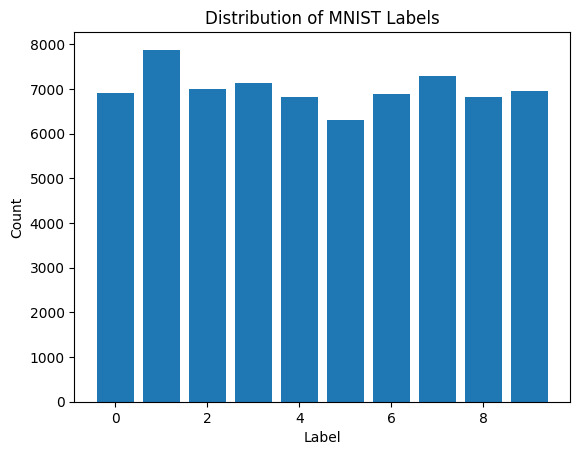

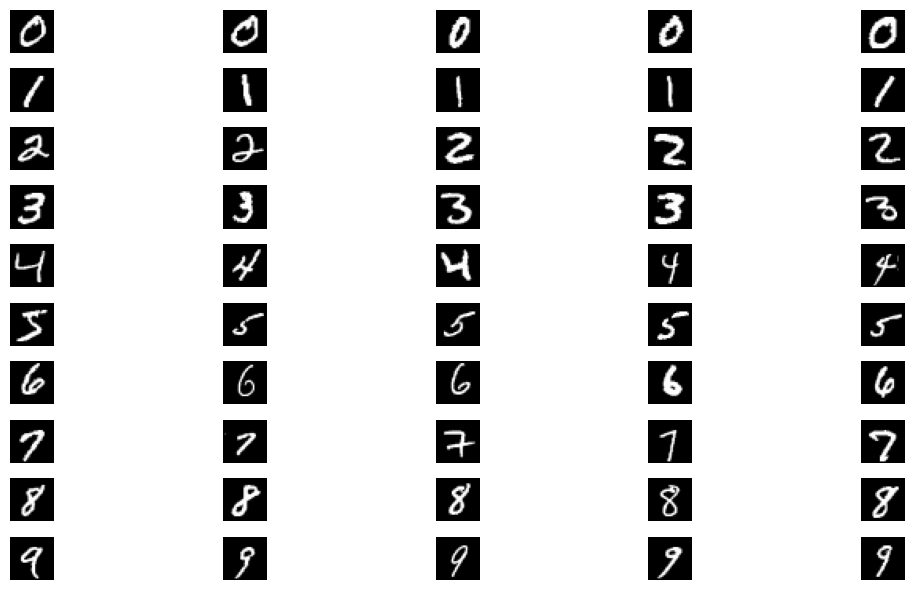

In [188]:
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./', train=False, download=True, transform=transform)
mnist_train = torch.utils.data.ConcatDataset([mnist_train, mnist_test])

label_counts = np.zeros(10)
for _, label in mnist_train:
    label_counts[label] += 1

plt.bar(range(0, 10), label_counts)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of MNIST Labels')
plt.show()

samples_per_class = {}

for data, label in mnist_train:
    if label not in samples_per_class.keys():
        samples_per_class[label] = [data]
    else:
        if len(samples_per_class[label]) < 5:
            samples_per_class[label].append(data)

plt.figure(figsize=(12, 6))
for label, images in samples_per_class.items():
    for i, image in enumerate(images):
        plt.subplot(10, 5, label * 5 + i + 1)
        plt.imshow(image.squeeze().numpy(), cmap='gray')
        plt.axis('off')
plt.tight_layout()
plt.show()

In [189]:
train_size = int(6/7 * len(mnist_train))
val_size = int(0.1 * len(mnist_train))
test_size = len(mnist_train) - train_size - val_size

train_set, val_set, test_set = torch.utils.data.random_split(mnist_train, [train_size, val_size, test_size])

batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

In [192]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 16 * 4 * 4)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x


In [193]:
model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    correct = 0
    total = 0
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Epoch [{epoch + 1}/{num_epochs}] | Loss: {loss.item():.4f} | Validation Accuracy: {accuracy:.2f}%')

Epoch [1/10] | Loss: 0.0605 | Validation Accuracy: 97.16%
Epoch [2/10] | Loss: 0.0879 | Validation Accuracy: 97.86%
Epoch [3/10] | Loss: 0.0418 | Validation Accuracy: 98.51%
Epoch [4/10] | Loss: 0.0313 | Validation Accuracy: 98.43%
Epoch [5/10] | Loss: 0.2585 | Validation Accuracy: 98.59%
Epoch [6/10] | Loss: 0.0278 | Validation Accuracy: 98.74%
Epoch [7/10] | Loss: 0.0016 | Validation Accuracy: 98.61%
Epoch [8/10] | Loss: 0.0638 | Validation Accuracy: 98.74%
Epoch [9/10] | Loss: 0.0023 | Validation Accuracy: 98.59%
Epoch [10/10] | Loss: 0.0052 | Validation Accuracy: 98.76%


In [200]:
def visualize_feature_maps(model, image, layer_name):
    model.eval()
    feature_maps = None
    def hook(module, input, output):
        nonlocal feature_maps
        feature_maps = output
    target_layer = None
    for name, module in model.named_modules():
        if name == layer_name:
            target_layer = module
            break
    if target_layer is None:
        print(f"Layer '{layer_name}' not found in the model.")
        return
    hook_handle = target_layer.register_forward_hook(hook)
    with torch.no_grad():
        image = image.unsqueeze(0)
        model(image)
    hook_handle.remove()
    feature_maps = feature_maps.squeeze().cpu().numpy()
    num_feature_maps = feature_maps.shape[0]
    if num_feature_maps <= 4:
        rows, cols = 1, num_feature_maps
    else:
        cols = 4
        rows = int(np.ceil(num_feature_maps / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    for i in range(num_feature_maps):
        if rows > 1:
            ax = axes[i // cols, i % cols]
        else:
            ax = axes[i]
        ax.imshow(feature_maps[i], cmap='viridis')
        ax.axis('off')
        ax.set_title(f'Feature Map {i + 1}')
    plt.figure(figsize=(5, 5))
    plt.imshow(image.squeeze().cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.title('Input Image')
    plt.tight_layout()
    plt.show()

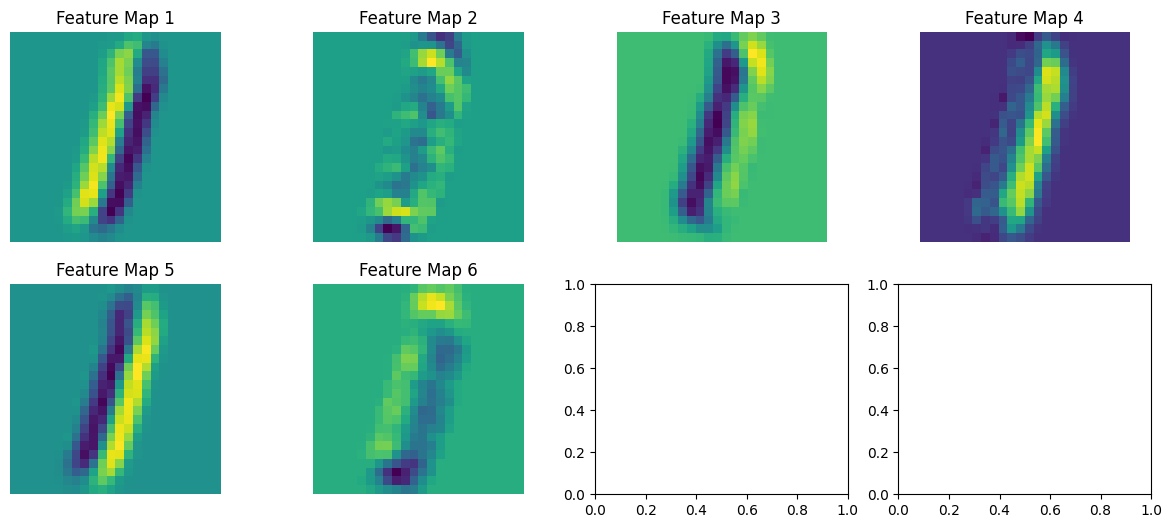

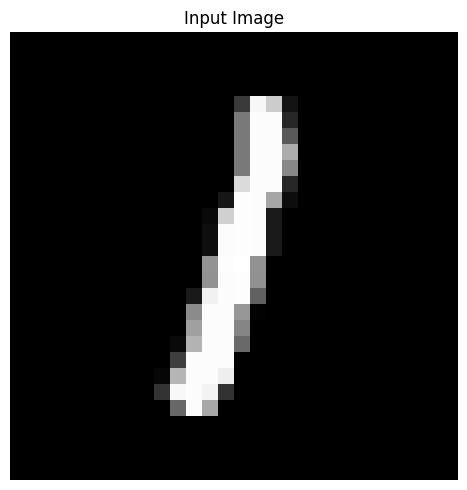

In [201]:
image, label = test_set[0]
layer_name = 'conv1'
visualize_feature_maps(model, image, layer_name)

# Q2.2

In [204]:
wandb.init(project="cv_assignment_2", entity="harshitaggarwal4")

config = wandb.config
config.learning_rate = [0.001, 0.01]
config.batch_size = [64, 128]
config.num_epochs = 10
config.optimizers = ['lion', 'adam']

best_accuracy = 0.0
best_model_state = None

transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./', train=True, download=True, transform=transform)

train_size = int(0.8 * len(mnist_train))
val_size = int(0.1 * len(mnist_train))
test_size = len(mnist_train) - train_size - val_size

train_set, val_set, test_set = torch.utils.data.random_split(mnist_train, [train_size, val_size, test_size])

def create_data_loader(dataset, batch_size):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

for lr in config.learning_rate:
    for batch_size in config.batch_size:
        for optimizer_ in config.optimizers:
            model = CNNModel()
            criterion = nn.CrossEntropyLoss()
            if optimizer_ == 'lion':
                optimizer = Lion(model.parameters(), lr=lr)
            else:
                optimizer = optim.Adam(model.parameters(), lr=lr)

            train_loader = create_data_loader(train_set, batch_size)
            val_loader = create_data_loader(val_set, batch_size)

            for epoch in range(config.num_epochs):
                model.train()
                for images, labels in train_loader:
                    optimizer.zero_grad()
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                model.eval()
                correct = 0
                total = 0
                for images, labels in val_loader:
                    outputs = model(images)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                accuracy = 100 * correct / total

                wandb.log({
                    "Learning Rate": lr,
                    "Batch Size": batch_size,
                    "Epoch": epoch + 1,
                    "Optimizer": optimizer_,
                    "Train Loss": loss.item(),
                    "Validation Accuracy": accuracy
                })

                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_model_state = model.state_dict()

torch.save(best_model_state, 'model_best.pth')

wandb.finish()

Batch Size,▁▁▁▁▁▁▁▁▁▁██████████▁▁▁▁▁▁▁▁▁▁██████████
Epoch,▁▃▄▆▇▁▃▄▆▇▁▃▄▆▇▁▃▄▆▇▁▃▄▆▇▁▃▄▆▇▁▃▄▆▇▁▃▄▆█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
Train Loss,▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▇▇▇▇▁▁▁▁▁▂█▆▇█▁▁▁▁▁
Validation Accuracy,████████████████████▂▁▁▁▁█████▇▁▂▂▁█████
Batch Size,128
Epoch,10
Learning Rate,0.01
Optimizer,adam
Train Loss,0.06487
Validation Accuracy,98.13333


# Observations:
Model best performs for a higher batch_size since then the bias towards a particular input decreases. Also, Adam optimizer seems to perform better than Lion here. Lower learning rate is preffered so that the model can go to the minima and thus doesn't skip over it.

# Q2.3

In [205]:
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./', train=False, download=True, transform=transform)
mnist_train = torch.utils.data.ConcatDataset([mnist_train, mnist_test])

train_size = int(6/7 * len(mnist_train))
val_size = int(0.1 * len(mnist_train))
test_size = len(mnist_train) - train_size - val_size

train_set, val_set, test_set = torch.utils.data.random_split(mnist_train, [train_size, val_size, test_size])

def create_data_loader(dataset, batch_size):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

batch_size = 64
learning_rate = 0.001
num_epochs = 10

best_model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_model.parameters(), lr=learning_rate)

train_loader = create_data_loader(train_set, batch_size)
val_loader = create_data_loader(val_set, batch_size)

for epoch in range(num_epochs):
    best_model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = best_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    best_model.eval()
    correct = 0
    total = 0
    for images, labels in val_loader:
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total

In [206]:
best_model.eval()
test_correct = 0
test_total = 0
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = best_model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

class_accuracy = []
for class_label in range(10):
    class_correct = sum([(p == class_label) and (t == class_label) for p, t in zip(predictions, true_labels)])
    class_total = true_labels.count(class_label)
    class_accuracy.append(class_correct / class_total)
    print(f"Accuracy for class {class_label}: {class_accuracy[-1] * 100:.2f}%")

print("Classification Report:\n", classification_report(true_labels, predictions))

Test Accuracy: 99.40%
Accuracy for class 0: 99.65%
Accuracy for class 1: 100.00%
Accuracy for class 2: 99.65%
Accuracy for class 3: 98.47%
Accuracy for class 4: 98.98%
Accuracy for class 5: 98.51%
Accuracy for class 6: 99.67%
Accuracy for class 7: 99.66%
Accuracy for class 8: 100.00%
Accuracy for class 9: 99.35%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       286
           1       0.99      1.00      1.00       329
           2       0.99      1.00      0.99       288
           3       1.00      0.98      0.99       327
           4       1.00      0.99      0.99       295
           5       0.99      0.99      0.99       268
           6       0.99      1.00      1.00       304
           7       1.00      1.00      1.00       297
           8       0.99      1.00      1.00       300
           9       0.99      0.99      0.99       306

    accuracy                           0.99      3000
   macro avg

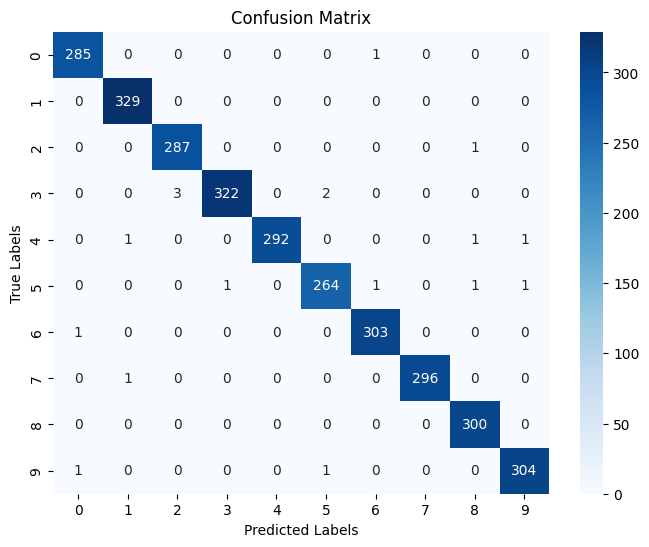

In [207]:
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Observations:
The best performing CNN here gives an overall accuracy of 99.4% while the SIFT-BoVW-SVM gave the highest accuracy of 85%.  This is a huge increase. Also, the CNN gets trained much faster as compared to the SIFT-BoVW-SVM.

# Q2.4

In [208]:
class DoubleConvCNN(nn.Module):
    def __init__(self):
        super(DoubleConvCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [209]:
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./', train=False, download=True, transform=transform)
mnist_train = torch.utils.data.ConcatDataset([mnist_train, mnist_test])

train_size = int(6/7 * len(mnist_train))
val_size = int(0.1 * len(mnist_train))
test_size = len(mnist_train) - train_size - val_size

train_set, val_set, test_set = torch.utils.data.random_split(mnist_train, [train_size, val_size, test_size])

def create_data_loader(dataset, batch_size):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

batch_size = 64
learning_rate = 0.001
num_epochs = 10

best_model = DoubleConvCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_model.parameters(), lr=learning_rate)

train_loader = create_data_loader(train_set, batch_size)
val_loader = create_data_loader(val_set, batch_size)

for epoch in range(num_epochs):
    best_model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = best_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    best_model.eval()
    correct = 0
    total = 0
    for images, labels in val_loader:
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total

In [210]:
best_model.eval()
test_correct = 0
test_total = 0
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = best_model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

class_accuracy = []
for class_label in range(10):
    class_correct = sum([(p == class_label) and (t == class_label) for p, t in zip(predictions, true_labels)])
    class_total = true_labels.count(class_label)
    class_accuracy.append(class_correct / class_total)
    print(f"Accuracy for class {class_label}: {class_accuracy[-1] * 100:.2f}%")

print("Classification Report:\n", classification_report(true_labels, predictions))

Test Accuracy: 99.60%
Accuracy for class 0: 99.65%
Accuracy for class 1: 99.39%
Accuracy for class 2: 100.00%
Accuracy for class 3: 100.00%
Accuracy for class 4: 98.98%
Accuracy for class 5: 99.63%
Accuracy for class 6: 99.67%
Accuracy for class 7: 98.99%
Accuracy for class 8: 100.00%
Accuracy for class 9: 99.67%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       286
           1       1.00      0.99      1.00       329
           2       0.99      1.00      1.00       288
           3       1.00      1.00      1.00       327
           4       1.00      0.99      0.99       295
           5       1.00      1.00      1.00       268
           6       1.00      1.00      1.00       304
           7       1.00      0.99      0.99       297
           8       1.00      1.00      1.00       300
           9       0.98      1.00      0.99       306

    accuracy                           1.00      3000
   macro av

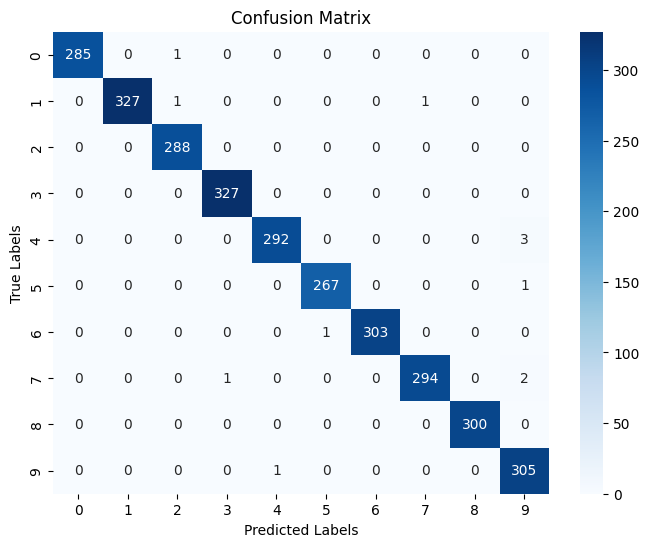

In [211]:
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Observations:
The regular CNN gave an accuracy of 99.4% while this one gave it to be 99.6%. There is an increase in the accuracy but very high as compared to the increase in the training time. It's a trade off between these two things.

# Q2.5

In [213]:
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./', train=False, download=True, transform=transform)
mnist_train = torch.utils.data.ConcatDataset([mnist_train, mnist_test])
# np.random.shuffle(mnist_train)

train_sizes = [600, 1800, 6000, 18000, 60000]
val_size_ratio = 0.1

def create_data_loader(dataset, batch_size):
        return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

test_accuracies = []

for train_size in train_sizes:
    val_size = int(val_size_ratio * train_size)
    test_size = len(mnist_train) - train_size - val_size
    train_set, val_set, test_set = torch.utils.data.random_split(mnist_train, [train_size, val_size, test_size])

    batch_size = 64
    learning_rate = 0.001
    num_epochs = 10

    best_model = DoubleConvCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(best_model.parameters(), lr=learning_rate)

    train_loader = create_data_loader(train_set, batch_size)
    val_loader = create_data_loader(val_set, batch_size)

    for epoch in range(num_epochs):
        best_model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = best_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        best_model.eval()
        correct = 0
        total = 0
        for images, labels in val_loader:
            outputs = best_model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total

    best_model.eval()
    test_correct = 0
    test_total = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = best_model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            predictions.extend(predicted.tolist())
            true_labels.extend(labels.tolist())

    test_accuracy = 100 * test_correct / test_total
    test_accuracies.append(test_accuracy)
    print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 91.57%
Test Accuracy: 95.00%
Test Accuracy: 97.30%
Test Accuracy: 98.53%
Test Accuracy: 99.80%


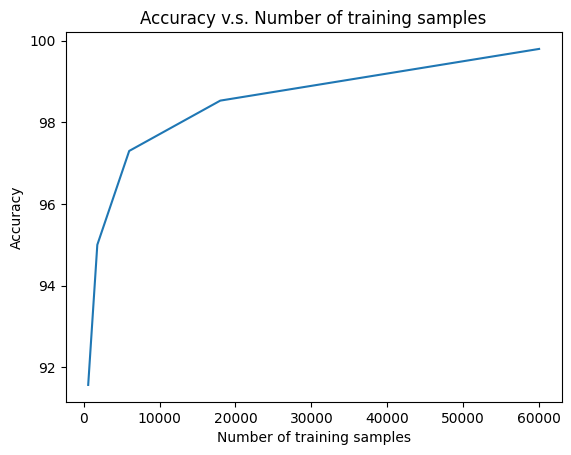

In [214]:
x_values = [600, 1800, 6000, 18000, 60000]
plt.plot(x_values, test_accuracies)
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.title('Accuracy v.s. Number of training samples')
plt.show()

# Observations:
As we increase the number of training samples, the accuracy increases as the number of inputs the model sees increases. More the input data, better the model learns and better it performs.

# Q2.6

In [91]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [5]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_heads, output_dim):
        super(TransformerModel, self).__init__()
        self.encoder_layer = TransformerEncoderLayer(input_dim, num_heads, hidden_dim, batch_first=True)
        self.transformer_encoder = TransformerEncoder(self.encoder_layer, num_layers)
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x

input_dim = 28*28
hidden_dim = 64
num_layers = 2
num_heads = 4
output_dim = 10
model = TransformerModel(input_dim, hidden_dim, num_layers, num_heads, output_dim)

In [101]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.view(-1, 28*28).to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.view(-1, 28*28).to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, accuracy

epochs = 10
for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    test_loss, accuracy = test(model, test_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")

Epoch 1/10, Train Loss: 0.3953, Test Loss: 0.0038, Accuracy: 92.65%
Epoch 2/10, Train Loss: 0.2647, Test Loss: 0.0030, Accuracy: 94.12%
Epoch 3/10, Train Loss: 0.2261, Test Loss: 0.0037, Accuracy: 93.06%
Epoch 4/10, Train Loss: 0.2081, Test Loss: 0.0026, Accuracy: 95.12%
Epoch 5/10, Train Loss: 0.1945, Test Loss: 0.0026, Accuracy: 94.97%
Epoch 6/10, Train Loss: 0.1805, Test Loss: 0.0024, Accuracy: 95.56%
Epoch 7/10, Train Loss: 0.1693, Test Loss: 0.0026, Accuracy: 94.70%
Epoch 8/10, Train Loss: 0.1675, Test Loss: 0.0026, Accuracy: 95.27%
Epoch 9/10, Train Loss: 0.1594, Test Loss: 0.0024, Accuracy: 95.49%
Epoch 10/10, Train Loss: 0.1522, Test Loss: 0.0024, Accuracy: 95.52%


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_size = 6000
test_size = len(mnist_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(mnist_dataset, [train_size, test_size])
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.view(-1, 28*28).to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.view(-1, 28*28).to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, accuracy

epochs = 10
for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    test_loss, accuracy = test(model, test_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")

Epoch 1/10, Train Loss: 0.8290, Test Loss: 0.0079, Accuracy: 83.13%
Epoch 2/10, Train Loss: 0.4371, Test Loss: 0.0062, Accuracy: 88.08%
Epoch 3/10, Train Loss: 0.3740, Test Loss: 0.0054, Accuracy: 89.83%
Epoch 4/10, Train Loss: 0.3463, Test Loss: 0.0055, Accuracy: 89.21%
Epoch 5/10, Train Loss: 0.2987, Test Loss: 0.0051, Accuracy: 90.38%
Epoch 6/10, Train Loss: 0.2912, Test Loss: 0.0051, Accuracy: 90.79%
Epoch 7/10, Train Loss: 0.2687, Test Loss: 0.0058, Accuracy: 89.61%
Epoch 8/10, Train Loss: 0.2669, Test Loss: 0.0055, Accuracy: 90.50%
Epoch 9/10, Train Loss: 0.2646, Test Loss: 0.0047, Accuracy: 91.54%
Epoch 10/10, Train Loss: 0.2100, Test Loss: 0.0052, Accuracy: 91.20%


# Observations:
Here we see that, the transformers performs worser than the CNNs. This is due to the fact that transformers are data heavy. They require a lot of data to correctly predict the classification. The gap in the 6k run is much greater than the 60k run. This is because transformers require a huge amount of data as the number of trainable parameters is very high.